In [1]:
# Importing the necessary basic libraries required for working on dataframe, data cleansing, visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Set your project path 
import os
project_path =  '/content/gdrive/My Drive/Capstone_NLP'
os.chdir(project_path)
os.getcwd()

'/content/gdrive/My Drive/Capstone_NLP'

In [4]:
# Reading the cleansed input data
deep_data = pd.read_excel('Cleansed_imb_df.xlsx')

In [5]:
#checking the first five rows of the cleaned data
print('First five rows of cleaned data are:\n')
deep_data.head()

First five rows of cleaned data are:



,Unnamed: 0,Cleansed_Desc,Assignment_Group,Counts
0,0,login issue verified user detail employee mana...,GRP_0,3206
1,1,outlook hmjdrvpb komuaywn team meeting skype m...,GRP_0,3206
2,2,cant log vpn eylqgodm ybqkwiam hi not log vpn ...,GRP_0,3206
3,3,unable access hr tool page unable access hr to...,GRP_0,3206
4,4,skype error skype error,GRP_0,3206


In [6]:
# Dropping the unnecessary columns
cols=['Unnamed: 0', 'Counts']
deep_data.drop(columns=cols,inplace=True)

In [7]:
print('Data after deleting the columns')
print(deep_data.head(2))
print(deep_data.shape)

Data after deleting the columns
                                       Cleansed_Desc Assignment_Group
0  login issue verified user detail employee mana...            GRP_0
1  outlook hmjdrvpb komuaywn team meeting skype m...            GRP_0
(7904, 2)


In [8]:
# Basic info of the dataset
deep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7904 entries, 0 to 7903
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Cleansed_Desc     7904 non-null   object
 1   Assignment_Group  7904 non-null   object
dtypes: object(2)
memory usage: 123.6+ KB


In [9]:
# Removing any missing values
deep_data.dropna(axis=0, subset=['Cleansed_Desc'], inplace=True)
deep_data.reset_index(drop=True, inplace=True)

In [10]:
deep_data.shape

(7904, 2)

In [11]:
# Tensorflow version 1.x specifically needed for the Universal Sentence Encoder to run with tensorflow

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [22]:
# Importing all the necessary libraries required for deep learning model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM, TimeDistributed, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#### 4. Universal Sentence Encoder

This is one of the ways to generate word embeddings for the sentences. Unlike Word2Vec or Glove embeddings, this one generates a fixed length 512 dimensional vector word embedding of the entire sentence, which has two variants - one with a 6 layer Transformer rchitecture, and the other using Deep Averarging Network

In [ ]:
print(tf.__version__)
print(hub.__version__)

1.15.2
0.8.0


In [ ]:
# Disabling eager execution of tensorflow
tf.compat.v1.disable_eager_execution()

In [ ]:
from absl import logging
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/3'

#Load Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Generating sample embeddings for the first 2 descriptions
messages = [deep_data['Cleansed_Desc'][0], deep_data['Cleansed_Desc'][1]]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
message_embeddings.shape

(2, 512)

So for the two descriptions given as input, we see that two embeddings have been created, each with 512 dimensions. Let's proceed using this embedding on the entire dataset

In [ ]:
# Creating a list of descriptions in order to feed to embed function
cleansed_list = []
for i in range(deep_data.shape[0]):
  cleansed_list.append(deep_data['Cleansed_Desc'][i])

# Splitting the descriptions so as to avoid embed function encountering OOM resource exhaused error
cleansed_list1 = cleansed_list[0:3000]
cleansed_list2 = cleansed_list[3000:5000]
cleansed_list3 = cleansed_list[5000:7904]

In [ ]:
# Creating Universal Sentence Encoder embedding of fixed-length 512 dimensions
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  embedding_matrix1 = session.run(embed(cleansed_list1))
  embedding_matrix2 = session.run(embed(cleansed_list2))
  embedding_matrix3 = session.run(embed(cleansed_list3))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
# Concatenating the above three generated embeddings 
embedding_matrix = np.concatenate((embedding_matrix1, embedding_matrix2, embedding_matrix3))
print(embedding_matrix.shape)

(7904, 512)


In [ ]:
# Creating independent and target variables
t = Tokenizer(num_words=8000)
t.fit_on_texts(deep_data['Cleansed_Desc'])
x = t.texts_to_sequences(deep_data['Cleansed_Desc'])
x = pad_sequences(x, padding='post', maxlen = 200)
y = np.asarray(pd.get_dummies(deep_data['Assignment_Group']), dtype=np.int8)

# Splitting the dataset into train and test sets

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=2018)

print('Training dataset : ')
print(x_train.shape, y_train.shape)
print('Test dataset : ')
print(x_test.shape, y_test.shape)

Training dataset : 
(6323, 200) (6323, 54)
Test dataset : 
(1581, 200) (1581, 54)


In [ ]:
# Remove the warning messages
tf.logging.set_verbosity(tf.logging.ERROR)

Model 10 : LSTM with Universal Sentence Encoder

In [ ]:
num_sentences=embedding_matrix.shape[0]
embedding_size=embedding_matrix.shape[1]
max_len=200
# Initialising and defining the layers of the model
model_lstm = Sequential()

e = Embedding(num_sentences, embedding_size,  input_length=max_len, weights=[embedding_matrix])
model_lstm.add(e)
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, trainable=True))
model_lstm.add(Dense(54, activation='softmax'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 512)          4046848   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                147712    
_________________________________________________________________
dense (Dense)                (None, 54)                3510      
Total params: 4,198,070
Trainable params: 4,198,070
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Defining the callbacks
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_acc", factor=0.5, patience=2, min_lr=1e-7, verbose=1, mode="max")

In [ ]:
# Compile and fit the model
from tensorflow.keras.optimizers import Adam
opt = Adam(0.1)
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_history = model_lstm.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2, callbacks=[stop, reduce_lr])

Train on 5058 samples, validate on 1265 samples
Epoch 1/10
5058/5058 [==============================] - 30s 6ms/sample - loss: 2.8779 - acc: 0.4039 - val_loss: 2.7791 - val_acc: 0.3889
Epoch 2/10
5058/5058 [==============================] - 28s 6ms/sample - loss: 2.7132 - acc: 0.4085 - val_loss: 2.7823 - val_acc: 0.3889
Epoch 3/10
5058/5058 [==============================] - 28s 6ms/sample - loss: 2.7106 - acc: 0.4089 - val_loss: 2.7732 - val_acc: 0.3905
Epoch 4/10
5058/5058 [==============================] - 28s 6ms/sample - loss: 2.7104 - acc: 0.4104 - val_loss: 2.7689 - val_acc: 0.3913
Epoch 5/10
5058/5058 [==============================] - 28s 6ms/sample - loss: 2.7047 - acc: 0.4112 - val_loss: 2.7675 - val_acc: 0.3913
Epoch 6/10
5056/5058 [============================>.] - ETA: 0s - loss: 2.7050 - acc: 0.4116
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5058/5058 [==============================] - 29s 6ms/sample - loss: 2.7052 - acc: 0.4114 - val

In [ ]:
val_acc_lstm = model_lstm_history.history['val_acc']
val_acc_lstm = np.round(np.max(val_acc_lstm) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_lstm))
test_acc_lstm = model_lstm.evaluate(x_test,y_test)
test_acc_lstm = np.round(test_acc_lstm[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_lstm))

Validation accuracy : 39.13
1581/1581 [==============================] - 4s 2ms/sample - loss: 2.7101 - acc: 0.4111
Test accuracy : 41.11


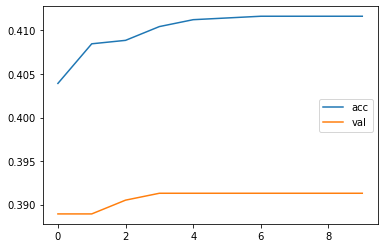

In [ ]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_lstm_history.epoch,model_lstm_history.history['acc'],label='acc')
plt.plot(model_lstm_history.epoch,model_lstm_history.history['val_acc'],label='val')
plt.legend()

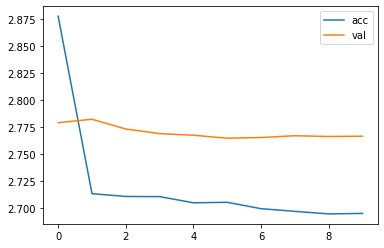

In [ ]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_lstm_history.epoch,model_lstm_history.history['loss'],label='acc')
plt.plot(model_lstm_history.epoch,model_lstm_history.history['val_loss'],label='val')
plt.legend()

In [ ]:
model_lstm.save('lstm_use.h5')

Model 11 : Bi-LSTM with Universal Sentence Encoder

In [ ]:
# Initialising and defining various layers of the model
model_blstm = Sequential()

e = Embedding(num_sentences, embedding_size,  input_length=max_len, weights=[embedding_matrix])
model_blstm.add(e)
model_blstm.add(Bidirectional(LSTM(64)))
model_blstm.add(Dense(54, activation='softmax'))

model_blstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 512)          4046848   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               295424    
_________________________________________________________________
dense_1 (Dense)              (None, 54)                6966      
Total params: 4,349,238
Trainable params: 4,349,238
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and fit the model
model_blstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_blstm_history = model_blstm.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=0.2, verbose=1, callbacks=[stop, reduce_lr])

Train on 5058 samples, validate on 1265 samples
Epoch 1/10
5058/5058 [==============================] - 35s 7ms/sample - loss: 2.1199 - acc: 0.5018 - val_loss: 2.5853 - val_acc: 0.4364
Epoch 2/10
5058/5058 [==============================] - 32s 6ms/sample - loss: 2.1382 - acc: 0.4939 - val_loss: 2.5580 - val_acc: 0.4593
Epoch 3/10
5058/5058 [==============================] - 32s 6ms/sample - loss: 2.1178 - acc: 0.4966 - val_loss: 2.5341 - val_acc: 0.4775
Epoch 4/10
5058/5058 [==============================] - 33s 7ms/sample - loss: 2.1662 - acc: 0.4986 - val_loss: 2.6263 - val_acc: 0.4609
Epoch 5/10
5000/5058 [============================>.] - ETA: 0s - loss: 2.1327 - acc: 0.5002
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
5058/5058 [==============================] - 33s 6ms/sample - loss: 2.1367 - acc: 0.4998 - val_loss: 2.5118 - val_acc: 0.4696
Epoch 6/10
5058/5058 [==============================] - 32s 6ms/sample - loss: 1.9533 - acc: 0.5202 - val_l

In [ ]:
val_acc_blstm = model_blstm_history.history['val_acc']
val_acc_blstm = np.round(np.max(val_acc_blstm) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_blstm))
test_acc_blstm = model_blstm.evaluate(x_test,y_test)
test_acc_blstm = np.round(test_acc_blstm[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_blstm))

Validation accuracy : 49.01
1581/1581 [==============================] - 6s 4ms/sample - loss: 2.2583 - acc: 0.5256
Test accuracy : 52.56


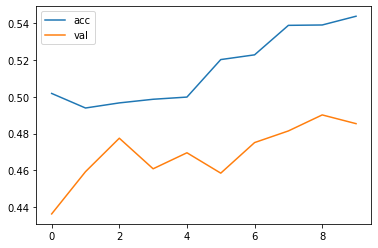

In [ ]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_blstm_history.epoch,model_blstm_history.history['acc'],label='acc')
plt.plot(model_blstm_history.epoch,model_blstm_history.history['val_acc'],label='val')
plt.legend()

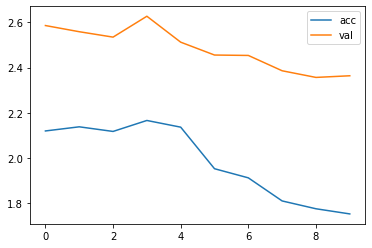

In [ ]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_blstm_history.epoch,model_blstm_history.history['loss'],label='acc')
plt.plot(model_blstm_history.epoch,model_blstm_history.history['val_loss'],label='val')
plt.legend()

In [ ]:
model_blstm.save('bi-lstm_use.h5')

Model 12 : Self Attention with Universal Sentence Encoder

In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=370bfb3fdd5016b2ef5776b4694f13b3ec2b2307a60eb2670aa2f2c7aef397a2
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [ ]:
from keras.layers import Dense, LSTM, Embedding, Bidirectional
from keras.models import Sequential
from keras_self_attention import SeqWeightedAttention

# Initialising and defining various layers of the model
model_sa = Sequential()
e = Embedding(num_sentences, embedding_size,  input_length=max_len, weights=[embedding_matrix])
model_sa.add(e)
model_sa.add(Bidirectional(LSTM(64, return_sequences=True)))
model_sa.add(SeqWeightedAttention())
model_sa.add(Dense(54, activation='softmax'))
model_sa.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 512)          4046848   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          295424    
_________________________________________________________________
seq_weighted_attention_2 (Se (None, 128)               129       
_________________________________________________________________
dense_1 (Dense)              (None, 54)                6966      
Total params: 4,349,367
Trainable params: 4,349,367
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and fit the model
from keras.optimizers import Adam
opt = Adam(0.1)
model_sa.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_sa_history = model_sa.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=0.2, verbose=1, callbacks=[stop, reduce_lr])

Train on 5058 samples, validate on 1265 samples
Epoch 1/10
5058/5058 [==============================] - 21s 4ms/step - loss: 2.5064 - accuracy: 0.4616 - val_loss: 2.5335 - val_accuracy: 0.4427
Epoch 2/10
5058/5058 [==============================] - 19s 4ms/step - loss: 2.3864 - accuracy: 0.4668 - val_loss: 2.4355 - val_accuracy: 0.4783
Epoch 3/10
5058/5058 [==============================] - 19s 4ms/step - loss: 2.3596 - accuracy: 0.4765 - val_loss: 2.4030 - val_accuracy: 0.4901
Epoch 4/10
5058/5058 [==============================] - 19s 4ms/step - loss: 2.3964 - accuracy: 0.4733 - val_loss: 2.4409 - val_accuracy: 0.4767
Epoch 5/10
5058/5058 [==============================] - 19s 4ms/step - loss: 2.3159 - accuracy: 0.4864 - val_loss: 2.4419 - val_accuracy: 0.4514
Epoch 6/10
5058/5058 [==============================] - 19s 4ms/step - loss: 2.3898 - accuracy: 0.4729 - val_loss: 2.4694 - val_accuracy: 0.4553
Epoch 7/10
5058/5058 [==============================] - 19s 4ms/step - loss: 2.265

In [ ]:
val_acc_sa = model_sa_history.history['val_accuracy']
val_acc_sa = np.round(np.max(val_acc_sa) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_sa))
test_acc_sa = model_sa.evaluate(x_test,y_test)
test_acc_sa = np.round(test_acc_sa[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_sa))

Validation accuracy : 49.01
1581/1581 [==============================] - 8s 5ms/step
Test accuracy : 49.59


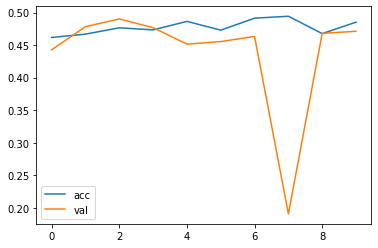

In [ ]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_sa_history.epoch,model_sa_history.history['accuracy'],label='acc')
plt.plot(model_sa_history.epoch,model_sa_history.history['val_accuracy'],label='val')
plt.legend()

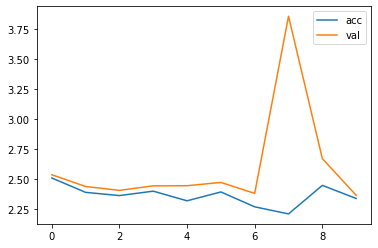

In [ ]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_sa_history.epoch,model_sa_history.history['loss'],label='acc')
plt.plot(model_sa_history.epoch,model_sa_history.history['val_loss'],label='val')
plt.legend()

In [ ]:
model_sa.save('sa_use.h5')

In [ ]:
use_df = pd.DataFrame({'Algorithm' : ['LSTM model with USE Embedding', ' Bi-LSTM model with USE Embedding', 
                                        'Self Attention with USE Embedding'],
                         'Validation Accuracy(%)' : [val_acc_lstm, val_acc_blstm, val_acc_sa],
                         'Test Accuracy(%)' : [test_acc_lstm, test_acc_blstm, test_acc_sa]})
use_df

,Algorithm,Validation Accuracy(%),Test Accuracy(%)
0,LSTM model with USE Embedding,39.13,41.11
1,Bi-LSTM model with USE Embedding,49.01,52.56
2,Self Attention with USE Embedding,49.01,49.59


### 5. BERT Embedding

Bi-Directional Encoder Representation for Transformers

BERT models were pre-trained using a large corpus of sentences. In brief, the training is done by masking a few words (~15% of the words according to the authors of the paper) in a sentence and tasking the model to predict the masked words. And as the model trains to predict, it learns to produce a powerful internal representation of words as word embedding.

BERT model has been introduced by Google in 2018 and it opened the doors for transfer learning in NLP.

In order to use BERT embedding, we will load Pytorch pre-trained BERT model

In [12]:
!pip install pytorch_pretrained_bert

In [13]:
from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel

In [14]:
# Initialising the BERTTokenizer using transfer learning and creating tokens

tokenizer1 = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_desc = [tokenizer1.tokenize(desc) for desc in deep_data['Cleansed_Desc'].values]

In [15]:
# Get the BERT word embeddings from the pre-trained model
def get_bert_embed_matrix():
    bert = BertModel.from_pretrained('bert-base-uncased')
    bert_embeddings = list(bert.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return mat

bert_embedding_matrix = get_bert_embed_matrix()
print('Loaded BERT Embedding Matrix of size: ', bert_embedding_matrix.shape)

Loaded BERT Embedding Matrix of size:  (30522, 768)


In [16]:
# Converting BERT Embedding matrix as a Data Frame
bert_embedding_matrix = pd.DataFrame(bert_embedding_matrix)
bert_embedding_matrix.shape

(30522, 768)

In [17]:
# Creating a copy of the cleansed dataset
deep_bert_df = deep_data.copy()
# Adding list of created tokens to the dataset
deep_bert_df['Tokenized_Desc'] = pd.Series(tokenized_desc)
deep_bert_df.head()

,Cleansed_Desc,Assignment_Group,Tokenized_Desc
0,login issue verified user detail employee mana...,GRP_0,"[log, ##in, issue, verified, user, detail, emp..."
1,outlook hmjdrvpb komuaywn team meeting skype m...,GRP_0,"[outlook, hm, ##j, ##dr, ##v, ##p, ##b, ko, ##..."
2,cant log vpn eylqgodm ybqkwiam hi not log vpn ...,GRP_0,"[can, ##t, log, vp, ##n, e, ##yl, ##q, ##go, #..."
3,unable access hr tool page unable access hr to...,GRP_0,"[unable, access, hr, tool, page, unable, acces..."
4,skype error skype error,GRP_0,"[sky, ##pe, error, sky, ##pe, error]"


In [18]:
# Creating individual tokens so as to feed to the models
tokenized_desc = []
for i in range(deep_bert_df.shape[0]):
  tokens = ",".join(str(token) for token in deep_bert_df['Tokenized_Desc'][i])
  tokenized_desc.append(tokens)

In [19]:
# Adding individually created tokens to the dataset
deep_bert_df['Tokens'] = pd.Series(tokenized_desc)
deep_bert_df.head()

,Cleansed_Desc,Assignment_Group,Tokenized_Desc,Tokens
0,login issue verified user detail employee mana...,GRP_0,"[log, ##in, issue, verified, user, detail, emp...","log,##in,issue,verified,user,detail,employee,m..."
1,outlook hmjdrvpb komuaywn team meeting skype m...,GRP_0,"[outlook, hm, ##j, ##dr, ##v, ##p, ##b, ko, ##...","outlook,hm,##j,##dr,##v,##p,##b,ko,##mu,##ay,#..."
2,cant log vpn eylqgodm ybqkwiam hi not log vpn ...,GRP_0,"[can, ##t, log, vp, ##n, e, ##yl, ##q, ##go, #...","can,##t,log,vp,##n,e,##yl,##q,##go,##dm,y,##b,..."
3,unable access hr tool page unable access hr to...,GRP_0,"[unable, access, hr, tool, page, unable, acces...","unable,access,hr,tool,page,unable,access,hr,to..."
4,skype error skype error,GRP_0,"[sky, ##pe, error, sky, ##pe, error]","sky,##pe,error,sky,##pe,error"


Now we have two columns for tokens - one as a list and the other as individual tokens. Let's use the list of tokens to find the unique tokens in the dataset, and the individual tokens to feed to the model

In [20]:
desc_set = set()
deep_bert_df['Tokenized_Desc'].apply(desc_set.update)
print('Number of unique tokens in the dataset : ', len(desc_set))

Number of unique tokens in the dataset :  7016


In [23]:
# Using the above unique number of tokens let's fix the maximum vocabulary words as 8000
t = Tokenizer(num_words=8000)
t.fit_on_texts(deep_bert_df['Tokens'])

In [24]:
# Defining x and y for the model
x = t.texts_to_sequences(deep_bert_df['Tokens'])
x = pad_sequences(x, padding='post', maxlen = 200)
y = np.asarray(pd.get_dummies(deep_bert_df['Assignment_Group']), dtype=np.int8)

In [25]:
#Train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2020)
print(x_train.shape)
print(x_test.shape)

(6323, 200)
(1581, 200)


Model 13 : LSTM with BERT Embedding

In [26]:
# Model building, compiling and summary

vocab_size=bert_embedding_matrix.shape[0] # 30522 from transfer learning
embedding_size=bert_embedding_matrix.shape[1] #768 from transfer learning
max_len=200 # Based on the mean length of sentences in the dataset

# Remove the warning messages
tf.logging.set_verbosity(tf.logging.ERROR)

model_bert = Sequential()

e = Embedding(vocab_size, embedding_size, input_length=max_len, weights=[bert_embedding_matrix])
model_bert.add(e)
model_bert.add(LSTM(64))
model_bert.add(Dense(54, activation = 'softmax'))

model_bert.compile(optimizer='Adam', loss=['binary_crossentropy'], metrics=['accuracy'])

model_bert.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 768)          23440896  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                213248    
_________________________________________________________________
dense (Dense)                (None, 54)                3510      
Total params: 23,657,654
Trainable params: 23,657,654
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Fit the model

model_bert_history = model_bert.fit(x_train,y_train, epochs=2, validation_split=0.2)

Train on 5058 samples, validate on 1265 samples
Epoch 1/2
5058/5058 [==============================] - 50s 10ms/sample - loss: 0.0694 - acc: 0.9814 - val_loss: 0.0665 - val_acc: 0.9815
Epoch 2/2
5058/5058 [==============================] - 49s 10ms/sample - loss: 0.0673 - acc: 0.9815 - val_loss: 0.0666 - val_acc: 0.9815


In [29]:
val_acc_bert = model_bert_history.history['val_acc']
val_acc_bert = np.round(np.max(val_acc_bert) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_bert))
test_acc_bert = model_bert.evaluate(x_test,y_test)
test_acc_bert = np.round(test_acc_bert[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_bert))

Validation accuracy : 98.15
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0673 - acc: 0.9815
Test accuracy : 98.15


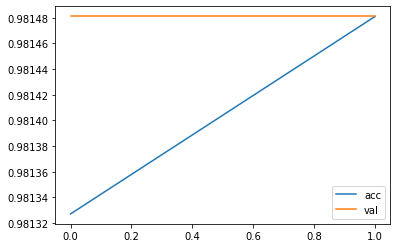

In [ ]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_bert_history.epoch,model_bert_history.history['accuracy'],label='acc')
plt.plot(model_bert_history.epoch,model_bert_history.history['val_accuracy'],label='val')
plt.legend()

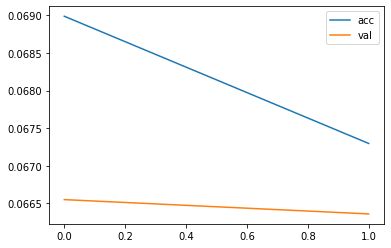

In [ ]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_bert_history.epoch,model_bert_history.history['loss'],label='acc')
plt.plot(model_bert_history.epoch,model_bert_history.history['val_loss'],label='val')
plt.legend()

In [ ]:
model_bert.save('lstm_bert.h5')

Model 14 : Bi-LSTM with BERT Embedding

In [30]:
# Model building, compiling and summary

vocab_size=bert_embedding_matrix.shape[0]
embedding_size=bert_embedding_matrix.shape[1]
max_len=200

model_bert_blstm = Sequential()

e = Embedding(vocab_size, embedding_size, input_length=max_len, weights=[bert_embedding_matrix])
model_bert_blstm.add(e)
model_bert_blstm.add(Bidirectional(LSTM(64)))
model_bert_blstm.add(Dense(54, activation = 'softmax'))

model_bert_blstm.compile(optimizer='Adam', loss=['binary_crossentropy'], metrics=['accuracy'])

model_bert_blstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 768)          23440896  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               426496    
_________________________________________________________________
dense_1 (Dense)              (None, 54)                6966      
Total params: 23,874,358
Trainable params: 23,874,358
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Fit the model
model_bert_blstm_history = model_bert_blstm.fit(x_train,y_train, epochs=2, validation_split=0.2)

Train on 5058 samples, validate on 1265 samples
Epoch 1/2
5058/5058 [==============================] - 103s 20ms/sample - loss: 0.0609 - acc: 0.9840 - val_loss: 0.0506 - val_acc: 0.9859
Epoch 2/2
5058/5058 [==============================] - 102s 20ms/sample - loss: 0.0454 - acc: 0.9875 - val_loss: 0.0449 - val_acc: 0.9871


In [33]:
val_acc_bert_blstm = model_bert_blstm_history.history['val_acc']
val_acc_bert_blstm = np.round(np.max(val_acc_bert_blstm) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_bert_blstm))
test_acc_bert_blstm = model_bert_blstm.evaluate(x_test,y_test)
test_acc_bert_blstm = np.round(test_acc_bert_blstm[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_bert_blstm))

Validation accuracy : 98.71
1581/1581 [==============================] - 6s 4ms/sample - loss: 0.0468 - acc: 0.9868
Test accuracy : 98.68


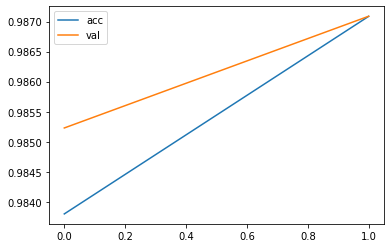

In [ ]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_bert_blstm_history.epoch,model_bert_blstm_history.history['accuracy'],label='acc')
plt.plot(model_bert_blstm_history.epoch,model_bert_blstm_history.history['val_accuracy'],label='val')
plt.legend()

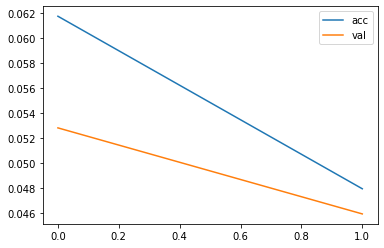

In [ ]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_bert_blstm_history.epoch,model_bert_blstm_history.history['loss'],label='acc')
plt.plot(model_bert_blstm_history.epoch,model_bert_blstm_history.history['val_loss'],label='val')
plt.legend()

In [ ]:
model_bert_blstm.save('blstm_bert.h5')

Model 15 : Self Attention layer with BERT Embedding

In [34]:
!pip install keras-self-attention

In [37]:
# Import Weighted Self Attention layer
import keras
from keras_self_attention import SeqWeightedAttention
from keras.layers import Embedding, LSTM, Bidirectional, Dense

# Model building, compiling and summary
vocab_size=bert_embedding_matrix.shape[0]
embedding_size=bert_embedding_matrix.shape[1]
max_len=200

model_bert_sa = keras.models.Sequential()

e = Embedding(vocab_size, embedding_size, input_length=max_len, weights=[bert_embedding_matrix])
model_bert_sa.add(e)
model_bert_sa.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bert_sa.add(SeqWeightedAttention())
model_bert_sa.add(Dense(54, activation = 'softmax'))

model_bert_sa.compile(optimizer='Adam', loss=['binary_crossentropy'], metrics=['accuracy'])

model_bert_sa.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 768)          23440896  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          426496    
_________________________________________________________________
seq_weighted_attention_2 (Se (None, 128)               129       
_________________________________________________________________
dense_1 (Dense)              (None, 54)                6966      
Total params: 23,874,487
Trainable params: 23,874,487
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Fit the model
model_bert_sa_history = model_bert_sa.fit(x_train,y_train, epochs=2, validation_split=0.2)

Train on 5058 samples, validate on 1265 samples
Epoch 1/2
5058/5058 [==============================] - 62s 12ms/step - loss: 0.0384 - accuracy: 0.9891 - val_loss: 0.0405 - val_accuracy: 0.9881
Epoch 2/2
5058/5058 [==============================] - 63s 12ms/step - loss: 0.0315 - accuracy: 0.9905 - val_loss: 0.0411 - val_accuracy: 0.9882


In [40]:
val_acc_bert_sa = model_bert_sa_history.history['val_accuracy']
val_acc_bert_sa = np.round(np.max(val_acc_bert_sa) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_bert_sa))
test_acc_bert_sa = model_bert_sa.evaluate(x_test,y_test)
test_acc_bert_sa = np.round(test_acc_bert_sa[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_bert_sa))

Validation accuracy : 98.82
1581/1581 [==============================] - 8s 5ms/step
Test accuracy : 98.76


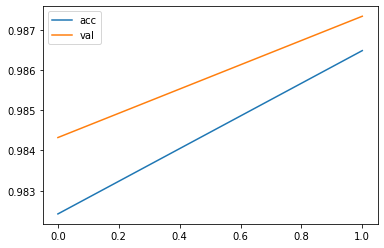

In [ ]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_bert_sa_history.epoch,model_bert_sa_history.history['accuracy'],label='acc')
plt.plot(model_bert_sa_history.epoch,model_bert_sa_history.history['val_accuracy'],label='val')
plt.legend()

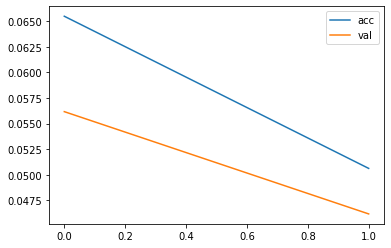

In [ ]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_bert_sa_history.epoch,model_bert_sa_history.history['loss'],label='acc')
plt.plot(model_bert_sa_history.epoch,model_bert_sa_history.history['val_loss'],label='val')
plt.legend()

In [ ]:
model_sa.save('sa_bert.h5')

In [41]:
bert_df = pd.DataFrame({'Algorithm' : ['LSTM model with BERT Embedding', ' Bi-LSTM model with BERT Embedding', 
                                        'Self Attention with BERT Embedding'],
                         'Validation Accuracy(%)' : [val_acc_bert, val_acc_bert_blstm, val_acc_bert_sa],
                         'Test Accuracy(%)' : [test_acc_bert, test_acc_bert_blstm, test_acc_bert_sa]})
bert_df

,Algorithm,Validation Accuracy(%),Test Accuracy(%)
0,LSTM model with BERT Embedding,98.15,98.15
1,Bi-LSTM model with BERT Embedding,98.71,98.68
2,Self Attention with BERT Embedding,98.82,98.76


###BERT with 74 groups(raw data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/Capstone_NLP')
os.getcwd()

'/content/drive/My Drive/Capstone_NLP'

In [ ]:
import pandas as pd
import numpy as np
# Reading the cleansed input data
inct_df = pd.read_excel('Cleansed_Raw_Data.xlsx')

In [ ]:
inct_df.head()

,Unnamed: 0,Unnamed: 0.1,Description,Assignment_Group,Translated_Desc,Cleansed_Desc
0,0,0,login issue -verified user details.(employee# ...,GRP_0,login issue -verified user details.(employee# ...,login issue verified user detail employee mana...
1,1,1,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...,GRP_0,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...,outlook hmjdrvpb komuaywn team meeting skype m...
2,2,2,cant log in to vpn \r\n\r\nreceived from: eylq...,GRP_0,cant log in to vpn \r\n\r\nreceived from: eylq...,cant log vpn eylqgodm ybqkwiam hi not log vpn ...
3,3,3,unable to access hr_tool page unable to access...,GRP_0,unable to access hr_tool page unable to access...,unable access hr tool page unable access hr to...
4,4,4,skype error skype error,GRP_0,skype error skype error,skype error skype error


In [ ]:
cols=['Unnamed: 0','Unnamed: 0.1','Description','Translated_Desc']
inct_df.drop(columns=cols,inplace=True)

In [ ]:
# Value counts
inct_df.Assignment_Group.value_counts()

GRP_0     3206
GRP_8      645
GRP_17     295
GRP_24     285
GRP_12     255
          ... 
GRP_61       1
GRP_73       1
GRP_70       1
GRP_64       1
GRP_67       1
Name: Assignment_Group, Length: 74, dtype: int64

As we see above there are 74 groups. We are applying BERT on the raw data

In [ ]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 4.6MB/s 


In [ ]:
from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel

In [ ]:
# Initialising the BERTTokenizer using transfer learning and creating tokens

tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_desc1 = [tokenizer2.tokenize(desc) for desc in inct_df['Cleansed_Desc'].values]

100%|██████████| 231508/231508 [00:00<00:00, 1200135.13B/s]


In [ ]:
# Get the BERT word embeddings from the pre-trained model
def get_bert_embed_matrix():
    bert = BertModel.from_pretrained('bert-base-uncased')
    bert_embeddings = list(bert.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return mat

bert_embedding_matrix = get_bert_embed_matrix()
print('Loaded BERT Embedding Matrix of size: ', bert_embedding_matrix.shape)

100%|██████████| 407873900/407873900 [00:12<00:00, 33465333.20B/s]


Loaded BERT Embedding Matrix of size:  (30522, 768)


In [ ]:
# Converting BERT Embedding matrix as a Data Frame
bert_embedding_matrix = pd.DataFrame(bert_embedding_matrix)
bert_embedding_matrix.shape

(30522, 768)

In [ ]:
# Creating a copy of the cleansed dataset
deep_bert_df1 = inct_df.copy()
# Adding list of created tokens to the dataset
deep_bert_df1['Tokenized_Desc'] = pd.Series(tokenized_desc1)
deep_bert_df1.head()

,Assignment_Group,Cleansed_Desc,Tokenized_Desc
0,GRP_0,login issue verified user detail employee mana...,"[log, ##in, issue, verified, user, detail, emp..."
1,GRP_0,outlook hmjdrvpb komuaywn team meeting skype m...,"[outlook, hm, ##j, ##dr, ##v, ##p, ##b, ko, ##..."
2,GRP_0,cant log vpn eylqgodm ybqkwiam hi not log vpn ...,"[can, ##t, log, vp, ##n, e, ##yl, ##q, ##go, #..."
3,GRP_0,unable access hr tool page unable access hr to...,"[unable, access, hr, tool, page, unable, acces..."
4,GRP_0,skype error skype error,"[sky, ##pe, error, sky, ##pe, error]"


In [ ]:
# Creating individual tokens so as to feed to the models
tokenized_desc1 = []
for i in range(deep_bert_df1.shape[0]):
  tokens = ",".join(str(token) for token in deep_bert_df1['Tokenized_Desc'][i])
  tokenized_desc1.append(tokens)

In [ ]:
# Adding individually created tokens to the dataset
deep_bert_df1['Tokens'] = pd.Series(tokenized_desc1)
deep_bert_df1.head()

,Assignment_Group,Cleansed_Desc,Tokenized_Desc,Tokens
0,GRP_0,login issue verified user detail employee mana...,"[log, ##in, issue, verified, user, detail, emp...","log,##in,issue,verified,user,detail,employee,m..."
1,GRP_0,outlook hmjdrvpb komuaywn team meeting skype m...,"[outlook, hm, ##j, ##dr, ##v, ##p, ##b, ko, ##...","outlook,hm,##j,##dr,##v,##p,##b,ko,##mu,##ay,#..."
2,GRP_0,cant log vpn eylqgodm ybqkwiam hi not log vpn ...,"[can, ##t, log, vp, ##n, e, ##yl, ##q, ##go, #...","can,##t,log,vp,##n,e,##yl,##q,##go,##dm,y,##b,..."
3,GRP_0,unable access hr tool page unable access hr to...,"[unable, access, hr, tool, page, unable, acces...","unable,access,hr,tool,page,unable,access,hr,to..."
4,GRP_0,skype error skype error,"[sky, ##pe, error, sky, ##pe, error]","sky,##pe,error,sky,##pe,error"


Now we have two columns for tokens - one as a list and the other as individual tokens. Let's use the list of tokens to find the unique tokens in the dataset, and the individual tokens to feed to the model

In [ ]:
desc_set = set()
deep_bert_df1['Tokenized_Desc'].apply(desc_set.update)
print('Number of unique tokens in the dataset : ', len(desc_set))

Number of unique tokens in the dataset :  7016


In [ ]:
# Usinf the above unique number of tokens let's fix the maximum vocabulary words as 8000
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer(num_words=8000)
t.fit_on_texts(deep_bert_df1['Tokens'])

In [ ]:
# Defining x and y for the model
from keras.preprocessing.sequence import pad_sequences
x = t.texts_to_sequences(deep_bert_df1['Tokens'])
x = pad_sequences(x, padding='post', maxlen = 200)
y = np.asarray(pd.get_dummies(deep_bert_df1['Assignment_Group']), dtype=np.int8)

In [ ]:
#Train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2020)
print(x_train.shape)
print(x_test.shape)

(6323, 200)
(1581, 200)


Model 16 : LSTM with BERT Embedding on Raw data

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Model building, compiling and summary
import tensorflow.compat.v1 as tf
from absl import logging

vocab_size=bert_embedding_matrix.shape[0] # 30522 from transfer learning
embedding_size=bert_embedding_matrix.shape[1] #768 from transfer learning
max_len=200 # Based on the mean length of sentences in the dataset

# Remove the warning messages
tf.logging.set_verbosity(tf.logging.ERROR)

model_bert = Sequential()

e = Embedding(vocab_size, embedding_size, input_length=max_len, weights=[bert_embedding_matrix],trainable=True)
model_bert.add(e)
model_bert.add(LSTM(128))
model_bert.add(Dense(74, activation = 'softmax'))

model_bert.compile(optimizer='Adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

model_bert.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 768)          23440896  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               459264    
_________________________________________________________________
dense (Dense)                (None, 74)                9546      
Total params: 23,909,706
Trainable params: 23,909,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-7, verbose=1, mode="max")
model_bert_history = model_bert.fit(x_train,y_train, epochs=10, validation_split=0.2, callbacks=[stop, reduce_lr])

Epoch 1/10
159/159 [==============================] - 37s 233ms/step - loss: 2.8300 - accuracy: 0.3968 - val_loss: 2.7097 - val_accuracy: 0.4213
Epoch 2/10
159/159 [==============================] - 37s 230ms/step - loss: 2.7608 - accuracy: 0.3996 - val_loss: 2.7076 - val_accuracy: 0.4213
Epoch 3/10
159/159 [==============================] - 37s 230ms/step - loss: 2.7546 - accuracy: 0.4009 - val_loss: 2.7017 - val_accuracy: 0.4237
Epoch 4/10
159/159 [==============================] - 36s 229ms/step - loss: 2.7489 - accuracy: 0.4027 - val_loss: 2.7018 - val_accuracy: 0.4237
Epoch 5/10
159/159 [==============================] - ETA: 0s - loss: 2.7430 - accuracy: 0.4027
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
159/159 [==============================] - 37s 230ms/step - loss: 2.7430 - accuracy: 0.4027 - val_loss: 2.7144 - val_accuracy: 0.4237
Epoch 6/10
159/159 [==============================] - 36s 229ms/step - loss: 2.7332 - accuracy: 0.4027 - val_l

In [ ]:
val_acc_bert = model_bert_history.history['val_accuracy']
val_acc_bert = np.round(np.max(val_acc_bert) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_bert))
test_acc_bert = model_bert.evaluate(x_test,y_test)
test_acc_bert = np.round(test_acc_bert[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_bert))

Validation accuracy : 42.37
50/50 [==============================] - 1s 11ms/step - loss: 2.7379 - accuracy: 0.4137
Test accuracy : 41.37


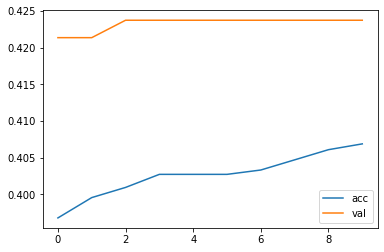

In [ ]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_bert_history.epoch,model_bert_history.history['accuracy'],label='acc')
plt.plot(model_bert_history.epoch,model_bert_history.history['val_accuracy'],label='val')
plt.legend()

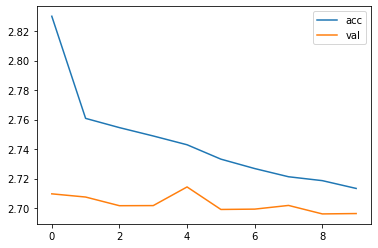

In [ ]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_bert_history.epoch,model_bert_history.history['loss'],label='acc')
plt.plot(model_bert_history.epoch,model_bert_history.history['val_loss'],label='val')
plt.legend()

Model 17 : Bi directional-LSTM with BERT Embedding on Raw data

In [51]:
# Model building, compiling and summary

vocab_size=bert_embedding_matrix.shape[0]
embedding_size=bert_embedding_matrix.shape[1]
max_len=200

model_bert_blstm = Sequential()

e = Embedding(vocab_size, embedding_size, input_length=max_len, weights=[bert_embedding_matrix],trainable=True)
model_bert_blstm.add(e)
model_bert_blstm.add(Bidirectional(LSTM(100),trainable=True))
model_bert_blstm.add(Dense(74, activation = 'softmax'))

model_bert_blstm.compile(optimizer='Adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

model_bert_blstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 768)          23440896  
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               695200    
_________________________________________________________________
dense_1 (Dense)              (None, 74)                14874     
Total params: 24,150,970
Trainable params: 24,150,970
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Fit the model
model_bert_blstm_history = model_bert_blstm.fit(x_train,y_train, epochs=10, validation_split=0.2, callbacks=[stop, reduce_lr])

Epoch 1/10
159/159 [==============================] - 40s 252ms/step - loss: 2.4477 - accuracy: 0.4666 - val_loss: 2.0201 - val_accuracy: 0.5233
Epoch 2/10
159/159 [==============================] - 39s 246ms/step - loss: 1.7742 - accuracy: 0.5704 - val_loss: 1.6774 - val_accuracy: 0.5953
Epoch 3/10
159/159 [==============================] - 39s 247ms/step - loss: 1.3046 - accuracy: 0.6663 - val_loss: 1.5184 - val_accuracy: 0.6182
Epoch 4/10
159/159 [==============================] - 39s 247ms/step - loss: 0.9602 - accuracy: 0.7459 - val_loss: 1.5462 - val_accuracy: 0.6111
Epoch 5/10
159/159 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.7985
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
159/159 [==============================] - 39s 247ms/step - loss: 0.7412 - accuracy: 0.7985 - val_loss: 1.5521 - val_accuracy: 0.6158
Epoch 6/10
159/159 [==============================] - 39s 246ms/step - loss: 0.5263 - accuracy: 0.8596 - val_l

In [53]:
val_acc_bert_blstm = model_bert_blstm_history.history['val_accuracy']
val_acc_bert_blstm = np.round(np.max(val_acc_bert_blstm) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_bert_blstm))
test_acc_bert_blstm = model_bert_blstm.evaluate(x_test,y_test)
test_acc_bert_blstm = np.round(test_acc_bert_blstm[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_bert_blstm))

Validation accuracy : 62.92
50/50 [==============================] - 1s 15ms/step - loss: 1.7483 - accuracy: 0.5984
Test accuracy : 59.84


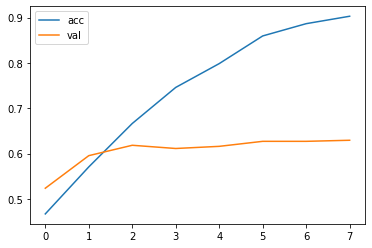

In [54]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_bert_blstm_history.epoch,model_bert_blstm_history.history['accuracy'],label='acc')
plt.plot(model_bert_blstm_history.epoch,model_bert_blstm_history.history['val_accuracy'],label='val')
plt.legend()

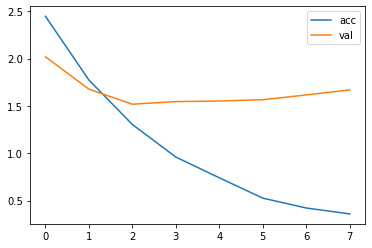

In [55]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_bert_blstm_history.epoch,model_bert_blstm_history.history['loss'],label='acc')
plt.plot(model_bert_blstm_history.epoch,model_bert_blstm_history.history['val_loss'],label='val')
plt.legend()

Model 18 : Self Attention Bi directional-LSTM with BERT Embedding on Raw data

In [56]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=74fdd41d1c73e211b407640d94bb64b12b0578c0d3675e8a7a14f6f0cb6e4442
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [57]:
# Import Weighted Self Attention layer
import keras
from keras_self_attention import SeqWeightedAttention

# Model building, compiling and summary
vocab_size=bert_embedding_matrix.shape[0]
embedding_size=bert_embedding_matrix.shape[1]
max_len=200

model_bert_sa = keras.models.Sequential()

e = Embedding(vocab_size, embedding_size, input_length=max_len, weights=[bert_embedding_matrix])
model_bert_sa.add(e)
model_bert_sa.add(Bidirectional(LSTM(100, return_sequences=True)))
model_bert_sa.add(SeqWeightedAttention())
model_bert_sa.add(Dense(74, activation = 'softmax'))

model_bert_sa.compile(optimizer='Adam', loss=['binary_crossentropy'], metrics=['accuracy'])

model_bert_sa.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 768)          23440896  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 200)          695200    
_________________________________________________________________
seq_weighted_attention (SeqW (None, 200)               201       
_________________________________________________________________
dense_2 (Dense)              (None, 74)                14874     
Total params: 24,151,171
Trainable params: 24,151,171
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Fit the model
model_bert_sa_history = model_bert_sa.fit(x_train,y_train, epochs=10, validation_split=0.2, callbacks=[stop, reduce_lr])

Epoch 1/10
159/159 [==============================] - 40s 250ms/step - loss: 0.0039 - accuracy: 0.9381 - val_loss: 0.0412 - val_accuracy: 0.6245
Epoch 2/10
159/159 [==============================] - 40s 250ms/step - loss: 0.0038 - accuracy: 0.9413 - val_loss: 0.0413 - val_accuracy: 0.6221
Epoch 3/10
159/159 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9413
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
159/159 [==============================] - 40s 250ms/step - loss: 0.0037 - accuracy: 0.9413 - val_loss: 0.0409 - val_accuracy: 0.6221
Epoch 4/10
159/159 [==============================] - 40s 250ms/step - loss: 0.0034 - accuracy: 0.9480 - val_loss: 0.0421 - val_accuracy: 0.6229
Epoch 5/10
159/159 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9472
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
159/159 [==============================] - 40s 251ms/step - loss: 0.0033 - accu

In [61]:
val_acc_bert_sa = model_bert_sa_history.history['val_accuracy']
val_acc_bert_sa = np.round(np.max(val_acc_bert_sa) * 100, 2)
print('Validation accuracy : %0.2f' %(val_acc_bert_sa))
test_acc_bert_sa = model_bert_sa.evaluate(x_test,y_test)
test_acc_bert_sa = np.round(test_acc_bert_sa[1] * 100, 2)
print('Test accuracy : %0.2f' %(test_acc_bert_sa))

Validation accuracy : 62.45
50/50 [==============================] - 1s 14ms/step - loss: 0.0439 - accuracy: 0.6028
Test accuracy : 60.28


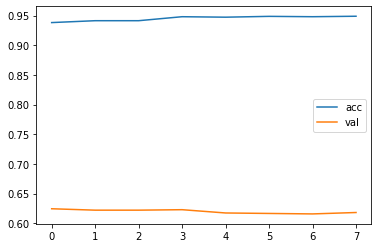

In [62]:
#plotting epochs versus the accuracy for Training and Validation
import matplotlib.pyplot as plt
plt.plot(model_bert_sa_history.epoch,model_bert_sa_history.history['accuracy'],label='acc')
plt.plot(model_bert_sa_history.epoch,model_bert_sa_history.history['val_accuracy'],label='val')
plt.legend()

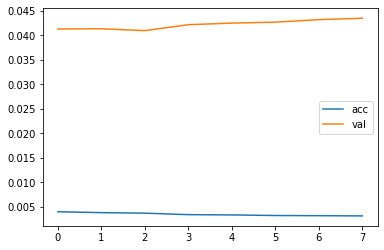

In [63]:
#Plotting epochs versus the loss for Training and Validation
plt.plot(model_bert_sa_history.epoch,model_bert_sa_history.history['loss'],label='acc')
plt.plot(model_bert_sa_history.epoch,model_bert_sa_history.history['val_loss'],label='val')
plt.legend()

In [64]:
bert_raw_df = pd.DataFrame({'Algorithm' : ['LSTM model with BERT Embedding', ' Bi-LSTM model with BERT Embedding', 
                                        'Self Attention with BERT Embedding'],
                         'Validation Accuracy(%)' : [val_acc_bert, val_acc_bert_blstm, val_acc_bert_sa],
                         'Test Accuracy(%)' : [test_acc_bert, test_acc_bert_blstm, test_acc_bert_sa]})
print('Results of BERT embedding on Raw dataset :')
bert_raw_df

Results of BERT embedding on Raw dataset :


,Algorithm,Validation Accuracy(%),Test Accuracy(%)
0,LSTM model with BERT Embedding,42.37,41.37
1,Bi-LSTM model with BERT Embedding,62.92,59.84
2,Self Attention with BERT Embedding,62.45,60.28


####Inferences on raw data

As we have tried applying BERT embedding on raw data, results show that the accuracy is less when compared to the dataset with 54 groups. This is mainly due to the highly imbalanced dataset, with majority of inidents belonging to GRP_0.

### Concatenating the results of DL models on dataset with 54 groups

In [ ]:
main_frame2 = pd.concat([use_df, bert_df])
print('Results of USE and BERT embeddings on Imbalanced dataset :')
main_frame2

Results of USE and BERT embeddings on Imbalanced dataset :


,Algorithm,Validation Accuracy(%),Test Accuracy(%)
0,LSTM model with USE Embedding,39.13,41.11
1,Bi-LSTM model with USE Embedding,49.01,52.56
2,Self Attention with USE Embedding,49.01,49.59
0,LSTM model with BERT Embedding,98.15,98.15
1,Bi-LSTM model with BERT Embedding,98.71,98.70
2,Self Attention with BERT Embedding,98.73,98.73


In [ ]:
main_frame2.to_excel('USE_BERT_Results_Imbalanced_Data.xlsx')

***Plotting the various model metrics***

In [66]:
df_1 = pd.read_excel('Glove_W2V_Results_Imbalanced_Data.xlsx') # This is generated from v1 file on DL models
df_2 = pd.read_excel('USE_BERT_Results_Imbalanced_Data.xlsx')

model_df = pd.concat([df_1, df_2], ignore_index=True)
model_df

,Algorithm,Validation Accuracy(%),Test Accuracy(%)
0,LSTM model with Self Embedding,42.37,41.429475
1,Bi-LSTM model with Self Embedding,61.26,60.531312
2,Self Attention with Self Embedding,59.29,56.356734
3,LSTM model with Glove Embedding,43.40,40.796965
4,Bi-LSTM model with Glove Embedding,67.51,63.820368
5,Self Attention with Glove Embedding,66.48,61.733079
6,LSTM model with Word2Vec Embedding,43.40,40.796965
7,Bi-LSTM model with Word2Vec Embedding,64.19,62.175840
8,Self Attention with Word2Vec Embedding,64.98,62.618595
9,LSTM model with USE Embedding,39.13,41.110000


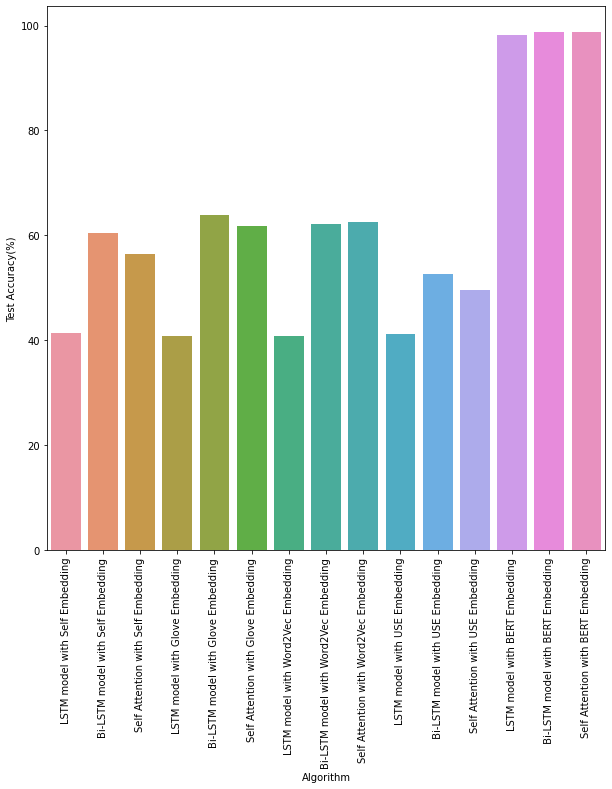

In [82]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(model_df['Algorithm'], model_df['Test Accuracy(%)'], )

plt.xticks(rotation=90)
plt.show()

So the best model so far is applying BERT embedding on the dataset with 54 groups, with either LSTM, Bi-LSTM or Self Attention. We have achieved around 98% accuracy for both validation and test sets. 

**Conclusion**

We have tried both ML and DL models on text dataset. We have applied various techniques in NLP for pre-processing the dataset, worked on couple of approaches for ML models , reduced the groups to 54 for DL models. 

Below are the conclusions:

1. As expected, Machine Learning models achieve less accuracy in predicting the groups when compared to Deep Learning models.

2. Out of all the models, we achieved best results for self attention Bi-LSTM model with BERT embedding on the dataset with 54 groups. 

3. We have also tried BERT on raw data, i.e., 74 groups. But the models seem to overfit the training data due to high imbalance. 

4. In order to decide the best model, we have to agree with the business users on selecting either the dataset with 54 groups or raw data. 

5. In the raw dataset, accuracy is compromised. We can check with the business in case if its possible to get more data on minority groups. If not possible, we need to trade-off accuracy on the raw dataset. 

6. If business is convinced to reduce the dataset with 54 groups, then we can showcase a model that can achieve the best accuracy, when using BERT embedding on Self Attention Bi-LSTM model. 

